In [1]:
import itk

In [2]:
import numpy as np
def loadFile(name):
    imageType = itk.Image[itk.F, 3]
    
    readerType = itk.ImageFileReader[imageType]
    
    reader = readerType.New()
    
    reader.SetFileName(name)
    
    im = reader.GetOutput()
    
    reader.Update()
    return np.array(itk.PyBuffer[imageType].GetArrayFromImage(im))
    
ct = loadFile("C:/Users/hasti/AppData/Local/Temp/Slicer/RemoteIO/CT-chest.nrrd")
horizSpace = .762
vertSpace = 2.5

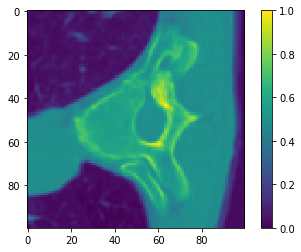

In [3]:
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

class SpineSampler:
    def __init__(self, ct, horizSpace, vertSpace, midline, depth):
        self.ct = ct
        self.horizSpace = horizSpace
        self.vertSpace = vertSpace
        self.midline = midline
        self.depth = depth

        i = np.linspace(0, 100, 100)
        j = np.linspace(-50, 50, 100)
        self.i, self.j = np.meshgrid(i, j)

    def sample(self, height, theta, horizoffset, depthoffset, scale=1):
        midline = self.midline + horizoffset
        depth = self.depth + depthoffset

        points = [np.arange(N) for N in self.ct.shape]

        xi = ((height + scale*self.j*np.sin(theta) ) / self.vertSpace, 
              (scale*self.i + depth) / horizSpace, 
              (midline + scale*self.j*np.cos(theta)) /self.horizSpace )
        xi = np.array([x.flatten() for x in xi]).transpose()
        res = interpn(points, self.ct, xi).reshape((100, 100))
        
        res -= np.min(res)
        
        res /= np.max(res)
        
        return res.reshape(100, 100, 1)
    def makeData(self, N):

        angle = np.random.uniform(-np.pi / 4, np.pi / 4, N)
        hoffset = np.random.uniform(-15, 15, N)
        voffset = np.random.uniform(-15, 15, N)
        height = np.random.uniform(70, 290, N)
        scale = np.random.uniform(.9, 1.1, N)
        
        data = np.array([
            self.sample(height[i], angle[i], voffset[i], hoffset[i], scale[i]) for i in range(N)
        ])
        return data, np.array([angle, height / 290]).transpose()
    
    
sampler = SpineSampler(ct, horizSpace, vertSpace, 200, 200)
plt.imshow(sampler.sample(240, np.pi / 7, 0, 10)[:,:,0])
plt.colorbar()
plt.show()

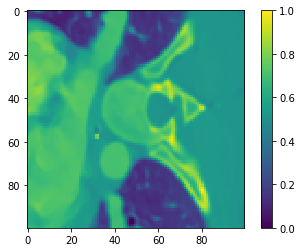

In [4]:
ct2 = loadFile("C:/Users/hasti/AppData/Local/Temp/Slicer/RemoteIO/CTA-cardio.nrrd")
sampler2 = SpineSampler(ct2, .933, 1.25, 260, 200)
plt.imshow(sampler2.sample(240, np.pi / 700, 0, 0)[:,:,0])
plt.colorbar()
plt.show()

In [3]:
import keras

Using TensorFlow backend.


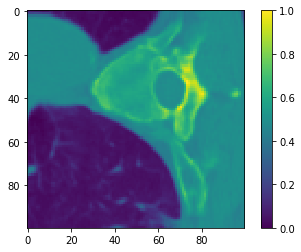

In [6]:
ct3 = np.flip(ct, 2)
sampler3 = SpineSampler(ct3, horizSpace, vertSpace, 200, 200)
plt.imshow(sampler3.sample(240, -np.pi / 7, 0, 0)[:,:,0])
plt.colorbar()
plt.show()

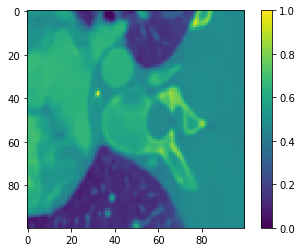

In [7]:
ct4 = np.flip(ct2, 2)
sampler4 = SpineSampler(ct4, .933, 1.25, 220, 200)
plt.imshow(sampler4.sample(240, -np.pi / 7, 0, 0)[:,:,0])
plt.colorbar()
plt.show()

In [8]:


data, classes = sampler.makeData(2000)
data2, classes2 = sampler2.makeData(2000)
data3, classes3 = sampler3.makeData(2000)
data4, classes4 = sampler4.makeData(2000)

td, tc = sampler.makeData(300)
td2, tc = sampler2.makeData(300)

td3, tc3 = sampler3.makeData(300)


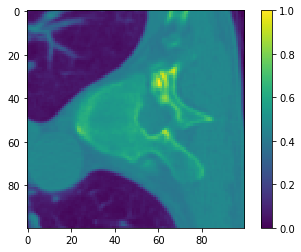

array([-0.466829 ,  0.6124573])

In [9]:
plt.imshow(data[1020, :, :, 0])
plt.colorbar()
plt.show()
classes[1020]

In [37]:
import pickle
import scipy.interpolate
import scipy.misc
class UltrasoundData:
    def __init__(self, filename):
        with open(filename, "rb") as file:
            self.rawImages, self.rawAngles = pickle.load(file)
            
        self.alpha, self.beta, self.gamma, self.otime = [
            np.array([o[name] for o in self.rawAngles]) for name in ("alpha", "beta", "gamma", "time")
        ]
        
        
        self.getAlpha = scipy.interpolate.interp1d(self.otime, self.alpha, assume_sorted=True)
        self.getBeta = scipy.interpolate.interp1d(self.otime, self.beta, assume_sorted=True)
        self.getGamma = scipy.interpolate.interp1d(self.otime, self.gamma, assume_sorted=True)
    def rotation(self, time):
        c = 2 * np.pi / 360
        #ALPHA IS NEGATIVE HERE, AS FAR AS I CAN TELL BUG IN SPEC
        return angletomatrix(-self.getAlpha(time) * c, self.getBeta(time) * c, self.getGamma(time) * c)
    
    def makeData(self):
        self.monoImages = np.sum(self.rawImages[1], 3).astype(np.float)
        self.rMatrices = np.array([self.rotation(time) for time in self.rawImages[0]])
        
        self.angles = np.arctan2(self.rMatrices[:,2,0 ], self.rMatrices[:, 2, 1])
        
        self.angles = np.concatenate([self.angles, -self.angles])
        
        

        self.data = np.array([scipy.misc.imresize(arr, (100, 100)) for arr in self.monoImages]).reshape(-1, 100, 100, 1) / 255
        
        self.data = np.concatenate([self.data, np.flip(self.data, 1)])
        
        self.classes = 3 * self.angles / np.pi

        
def angletomatrix(alpha, beta, gamma):
    """
    Returns a matrix that transforms from world coordinates to device coordinates
    """
    
    cA = np.cos(alpha)
    cB = np.cos(beta)
    cC = np.cos(gamma)
    sA = np.sin(alpha)
    sB = np.sin(beta)
    sC = np.sin(gamma)
    
    M1 = np.matrix([[cC,   0,  sC],
                    [0,    1,   0],
                    [-sC,  0,  cC]])
    
    M2 = np.matrix([[1,    0,   0],
                    [0,   cB, -sB],
                    [0,   sB,  cB]])
    
    M3 = np.matrix([[cA, -sA,   0],
                    [sA,  cA,   0],
                    [0,    0,   1]])
 
    return np.array((M1 * M2 * M3))
        
        


udata = UltrasoundData("../../ultrasoundHacks/August8SpineInWaterNoDetritus2.pickle")
udata.makeData()

In [6]:
import pickle
import scipy.interpolate
import scipy.misc
class UltrasoundData:
    def __init__(self, filename):
        with open(filename, "rb") as file:
            p = pickle.load(file)
            #print(p[0])
            self.rawImages = p[0]
            
            self.rot, self.trans, self.otime = p[1]
            self.otime = np.array(self.otime, dtype=np.float)
            self.otime /= 1000
        
        
        self.rotAngles = np.arctan2(self.rot[:, 2, 0], self.rot[:, 2, 2])
        
        
        self.getRotAngle = scipy.interpolate.interp1d(self.otime, self.rotAngles, assume_sorted=True)

   
    def makeData(self):
        self.monoImages = np.sum(self.rawImages[1], 3).astype(np.float)
        
        
        self.angles = self.getRotAngle(self.rawImages[0])
        self.angles = np.concatenate([self.angles, -self.angles])

        self.data = np.array([scipy.misc.imresize(arr, (100, 100)) for arr in self.monoImages]).reshape(-1, 100, 100, 1) / 255
        self.data = np.concatenate([self.data, np.flip(self.data, 2)])
        self.classes = 3 * self.angles / np.pi

udata = UltrasoundData("../../ultrasoundHacks/august10OpticalTrack.pickle")
udata.makeData()

udata2 = UltrasoundData("../../ultrasoundHacks/august10OpticalTrack2.pickle")
udata2.makeData()

In [5]:
import matplotlib.pyplot as plt
plt.plot(udata.classes)
plt.show()

NameError: name 'udata' is not defined

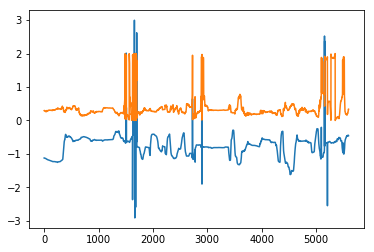

(30000, 100, 100, 1)

In [12]:
plt.plot(udata.angles[10000:15600])
plt.plot(udata.getAlpha(udata.rawImages[0])[10000:15600] / 180)
plt.show()
udata.data.shape

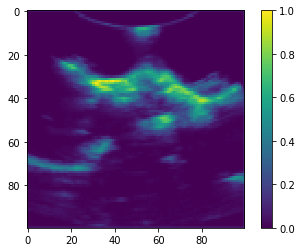

In [44]:
import matplotlib.pyplot as plt
plt.imshow(udata.data[5730, :, :, 0])
plt.colorbar()
plt.show()

In [7]:
from keras.models import Sequential
model = Sequential()

In [8]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [9]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1, activation='tanh'))

In [10]:
np.max(udata2.classes)

0.88622460197977626

In [11]:
import keras
model.compile(loss=keras.losses.mean_absolute_error,
              optimizer=keras.optimizers.sgd())

In [22]:

model.fit(np.concatenate([udata2.data, udata.data[:52000]]), 
          np.concatenate([udata2.classes, udata.classes[:52000]]),
          batch_size=100,
          epochs=10,
          verbose=1,
          validation_data=(udata.data[52000:], udata.classes[52000:]))

Train on 112000 samples, validate on 8000 samples
Epoch 1/10
112000/112000 [==============================] - 47s - loss: 0.0812 - val_loss: 0.0951
Epoch 2/10
112000/112000 [==============================] - 47s - loss: 0.0802 - val_loss: 0.0964
Epoch 3/10
112000/112000 [==============================] - 47s - loss: 0.0791 - val_loss: 0.0999
Epoch 4/10
112000/112000 [==============================] - 47s - loss: 0.0783 - val_loss: 0.0965
Epoch 5/10
112000/112000 [==============================] - 47s - loss: 0.0776 - val_loss: 0.0943
Epoch 6/10
112000/112000 [==============================] - 47s - loss: 0.0768 - val_loss: 0.0993
Epoch 7/10
112000/112000 [==============================] - 47s - loss: 0.0762 - val_loss: 0.0987
Epoch 8/10
112000/112000 [==============================] - 47s - loss: 0.0753 - val_loss: 0.0949
Epoch 9/10
112000/112000 [==============================] - 48s - loss: 0.0748 - val_loss: 0.0975
Epoch 10/10
112000/112000 [==============================] - 48s - l

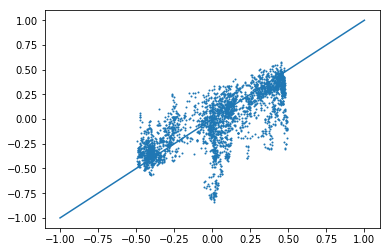

In [55]:
plt.scatter(udata.classes[57000:].flatten() , model.predict(udata.data[57000:]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

In [26]:
.0941

import h5py
model.save("Aug10,3:26.h5")

ImportError: `save_model` requires h5py.

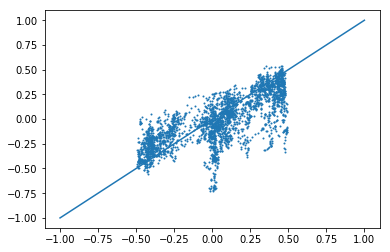

In [65]:
plt.scatter(udata.classes[57000:].flatten() , model.predict(udata.data[57000:]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

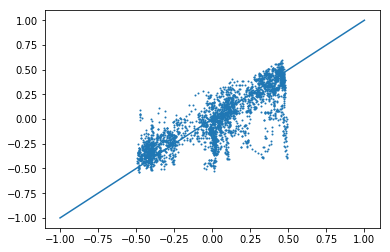

In [13]:
plt.scatter(udata.classes[57000:].flatten() , model.predict(udata.data[57000:]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

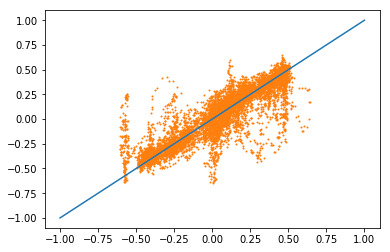

In [20]:
plt.scatter(udata.classes[52000:].flatten() , model.predict(udata.data[52000:]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

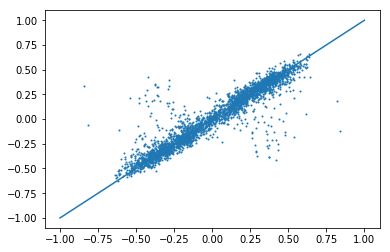

In [21]:
plt.scatter(udata2.classes[::20].flatten() , model.predict(udata2.data[::20]).flatten(), 1)
plt.plot([-1, 1], [-1, 1])
plt.show()

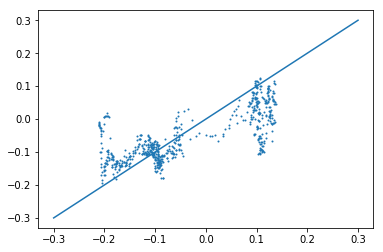

In [28]:
plt.scatter(udata.classes[6000:6600].flatten() , model.predict(udata.data[6000:6600]).flatten(), 1)
plt.plot([-.3, .3], [-.3, .3])
plt.show()

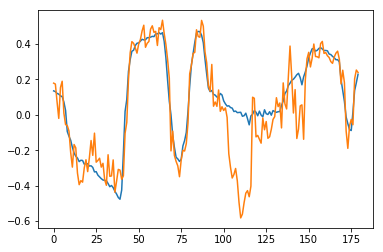

In [27]:
offset = 59000
length = 900

plt.plot(udata.classes[offset:offset + length:5])
plt.plot(model.predict(udata.data).flatten()[offset:offset + length:5])
plt.show()

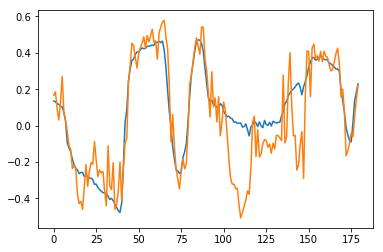

In [16]:
offset = 59000
length = 900

plt.plot(udata.classes[offset:offset + length:5])
plt.plot(model.predict(udata.data).flatten()[offset:offset + length:5])
plt.show()

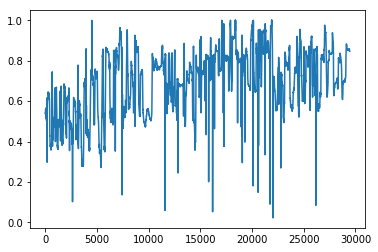

In [48]:
plt.plot(filtclasses)
plt.show()

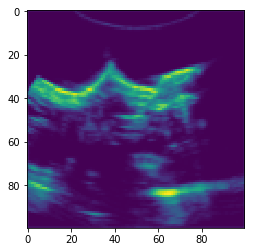

In [75]:
plt.imshow(udata.data[200, :, :, 0])
plt.show()

In [106]:
td.shape

(100, 100, 100, 1)

In [107]:
tc.shape

(100, 2)